In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import OneClassSVM

In [3]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/BeforeRemoveOutliers/013_N2O_After_HardVoting_Inliers.csv'
# file_path = '01.Dataset-Rofiqul/BeforeRemoveOutliers/014_N2O_After_SoftVoting_Inliers.csv'
# file_path = '01.Dataset-Rofiqul/BeforeRemoveOutliers/011_N2O_Soft_Voting_agriculture_dataset.csv'
file_path = '01.Dataset-Rofiqul/BeforeRemoveOutliers/019_data_with_COMBINATION_hard_soft_voting_outliers.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset for review
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2246 non-null   int64  
 1   Year                 2246 non-null   float64
 2   Experiment           2246 non-null   int64  
 3   DataUse              2246 non-null   int64  
 4   Replication          2246 non-null   int64  
 5   Month                2246 non-null   int64  
 6   Vegetation           2246 non-null   int64  
 7   VegType              2246 non-null   int64  
 8   N2O                  2246 non-null   float64
 9   N_rate               2246 non-null   float64
 10  PP2                  2246 non-null   float64
 11  PP7                  2246 non-null   float64
 12  AirT                 2246 non-null   float64
 13  DAF_TD               2246 non-null   float64
 14  DAF_SD               2246 non-null   float64
 15  WFPS25cm             2246 non-null   f

(   Date      Year  Experiment  DataUse  Replication  Month  Vegetation  \
 0   424  0.020682           1        0            0      3           0   
 1   360  0.020682           1        0            0      3           0   
 2   379  0.020682           1        0            0      3           0   
 3   382  0.020682           1        0            0      3           0   
 4   455  0.020682           1        0            0      7           0   
 
    VegType       N2O    N_rate  ...       NO3      Clay      Sand       SOM  \
 0        0 -0.125408  0.481233  ... -0.083017 -0.904182  0.796768 -0.642242   
 1        0 -0.185324  0.481233  ... -0.082259 -0.904182  0.796768 -0.642242   
 2        0 -0.137842  0.481233  ... -0.071667 -0.904182  0.796768 -0.642242   
 3        0 -0.144855  0.481233  ... -0.069647 -0.904182  0.796768 -0.642242   
 4        0 -0.158726  0.481233  ... -0.031903 -0.904182  0.796768 -0.642242   
 
    IF_Outlier  DBSCAN_Outlier  OCSVM_Outlier  Hard_Voting_Outlier

In [4]:
data.describe()

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,NO3,Clay,Sand,SOM,IF_Outlier,DBSCAN_Outlier,OCSVM_Outlier,Hard_Voting_Outlier,Soft_Vote_Outlier,Soft_Voting_Outlier
count,2246.000000,2.246000e+03,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.0,2.246000e+03,2.246000e+03,...,2.246000e+03,2.246000e+03,2.246000e+03,2.246000e+03,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000
mean,711.036064,1.518524e-14,1.083704,0.298308,0.882903,5.811220,0.266251,0.0,5.694465e-17,-5.061747e-17,...,8.858057e-17,1.012349e-16,-1.012349e-16,4.555572e-16,0.899377,-0.603740,0.894924,0.853072,0.918967,0.346394
std,383.586396,1.000223e+00,0.711429,0.457617,1.251850,3.531466,0.609056,0.0,1.000223e+00,1.000223e+00,...,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,0.437272,0.797359,0.446317,0.521909,0.394422,0.938298
min,0.000000,-2.744336e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-5.225740e-01,-2.548103e+00,...,-9.942643e-01,-9.041825e-01,-1.858163e+00,-6.422422e-01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,390.000000,-2.558196e-01,1.000000,0.000000,0.000000,3.000000,0.000000,0.0,-2.445164e-01,-1.424538e-01,...,-5.872878e-01,-9.041825e-01,-1.998760e-01,-6.422422e-01,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000
50%,727.000000,2.971840e-01,1.000000,0.000000,0.000000,6.000000,0.000000,0.0,-1.929840e-01,4.812329e-01,...,-1.965173e-01,-7.658135e-02,1.320853e-01,-6.310047e-01,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000
75%,1032.000000,5.736858e-01,2.000000,1.000000,2.000000,9.000000,0.000000,0.0,-8.008564e-02,4.812329e-01,...,8.159093e-02,6.137847e-01,7.967675e-01,-6.913331e-02,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000
max,1363.000000,1.403191e+00,2.000000,1.000000,4.000000,11.000000,2.000000,0.0,2.056053e+01,1.247477e+00,...,8.636700e+00,1.830044e+00,7.967675e-01,2.294188e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
print('Hard Voting')
print("Data Outlier: "+str((data['Hard_Voting_Outlier'] != 1).sum()))
print("Data Inlier: "+str((data['Hard_Voting_Outlier'] == 1).sum()))
print('Soft Voting')
print("Data Outlier: "+str((data['Soft_Voting_Outlier'] != 1).sum()))
print("Data Inlier: "+str((data['Soft_Voting_Outlier'] == 1).sum()))

Hard Voting
Data Outlier: 165
Data Inlier: 2081
Soft Voting
Data Outlier: 734
Data Inlier: 1512


In [6]:
#redeclare data variabel now only contain inlier
data=data[data['Soft_Voting_Outlier'] == 1]
data.head(),data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 2244
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1512 non-null   int64  
 1   Year                 1512 non-null   float64
 2   Experiment           1512 non-null   int64  
 3   DataUse              1512 non-null   int64  
 4   Replication          1512 non-null   int64  
 5   Month                1512 non-null   int64  
 6   Vegetation           1512 non-null   int64  
 7   VegType              1512 non-null   int64  
 8   N2O                  1512 non-null   float64
 9   N_rate               1512 non-null   float64
 10  PP2                  1512 non-null   float64
 11  PP7                  1512 non-null   float64
 12  AirT                 1512 non-null   float64
 13  DAF_TD               1512 non-null   float64
 14  DAF_SD               1512 non-null   float64
 15  WFPS25cm             1512 non-null   float6

(   Date      Year  Experiment  DataUse  Replication  Month  Vegetation  \
 0   424  0.020682           1        0            0      3           0   
 1   360  0.020682           1        0            0      3           0   
 2   379  0.020682           1        0            0      3           0   
 3   382  0.020682           1        0            0      3           0   
 4   455  0.020682           1        0            0      7           0   
 
    VegType       N2O    N_rate  ...       NO3      Clay      Sand       SOM  \
 0        0 -0.125408  0.481233  ... -0.083017 -0.904182  0.796768 -0.642242   
 1        0 -0.185324  0.481233  ... -0.082259 -0.904182  0.796768 -0.642242   
 2        0 -0.137842  0.481233  ... -0.071667 -0.904182  0.796768 -0.642242   
 3        0 -0.144855  0.481233  ... -0.069647 -0.904182  0.796768 -0.642242   
 4        0 -0.158726  0.481233  ... -0.031903 -0.904182  0.796768 -0.642242   
 
    IF_Outlier  DBSCAN_Outlier  OCSVM_Outlier  Hard_Voting_Outlier

## Prepare Train Test Split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Preprocess the data
features = data.drop(columns=['N2O'])  # Assuming 'N2O' is the target column
target = data['N2O']

# Encode categorical variables if any
label_encoders = {}
for column in features.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    features[column] = label_encoders[column].fit_transform(features[column])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Define X and y
X = scaled_features
y = target

In [9]:
# Function to train and evaluate XGBoost with different test sizes
def train_evaluate_xgboost(test_size):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Train the XGBoost model
    model = XGBClassifier()
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return model, accuracy, X_train.shape, X_test.shape

In [14]:
test_sizes = [0.2,0.25, 0.3, 0.35]
results = {}
# Initialize an empty list to store results
evaluation = []

def train_and_evaluate(test_size):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test Size: {test_size}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual N2O')
    plt.ylabel('Predicted N2O')
    plt.title(f'Actual vs Predicted N2O (Test Size: {test_size})')
    plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/002_1_ActualVsPredictedN2O_test_'+(str(int(test_size*100)))+'_NoOutlier.png')

    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Residuals Distribution (Test Size: {test_size})')
    plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/002_2_ResidualDistribution_test_'+(str(int(test_size*100)))+'_NoOutlier.png')

    plt.show()

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(model, max_num_features=10)
    plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/002_3_FeatureImportance_test_'+(str(int(test_size*100)))+'_NoOutlier.png')
    plt.title('Feature Importance')
    plt.show()

    return model, mse, rmse, mae, r2


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.2
Mean Squared Error: 0.0142782345157663
Root Mean Squared Error: 0.11949156671399995
Mean Absolute Error: 0.07384857083212178
R-squared: 0.6776179653704884


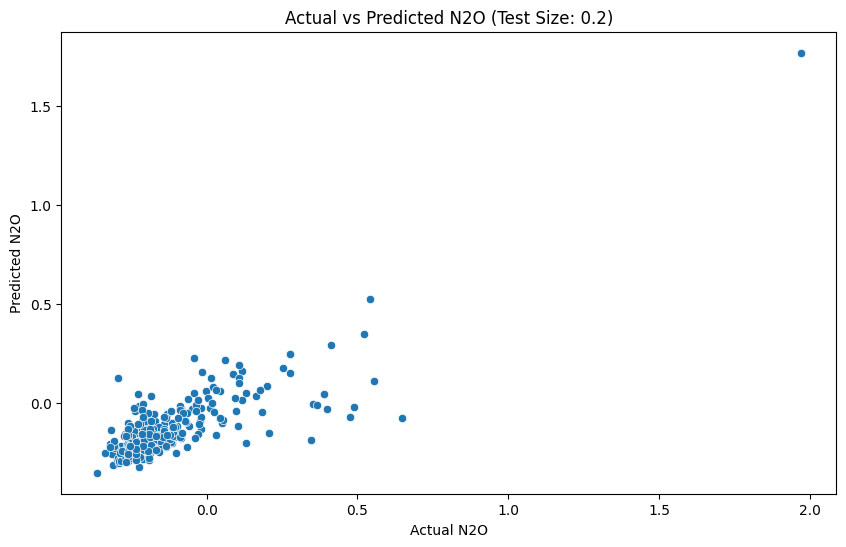

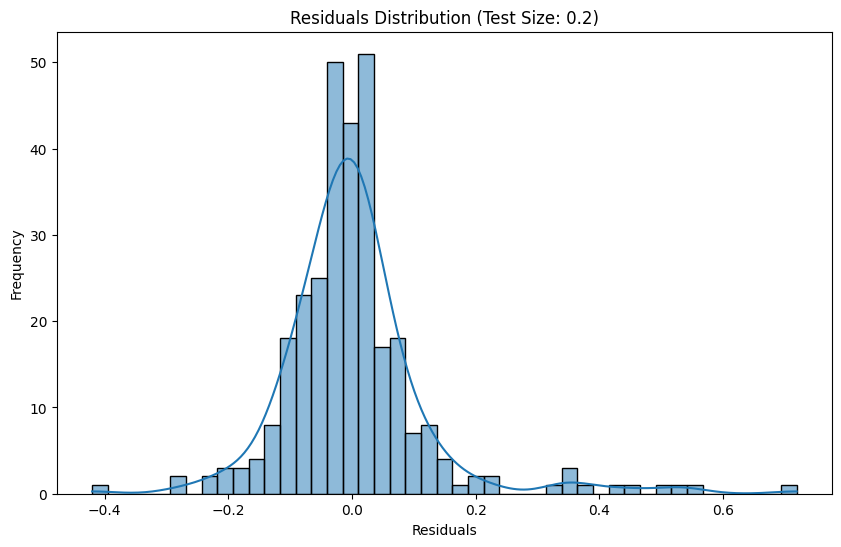

<Figure size 1000x600 with 0 Axes>

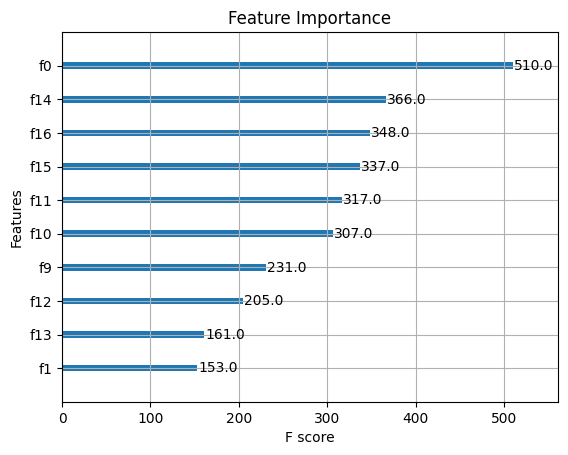

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.25
Mean Squared Error: 0.016526099209191087
Root Mean Squared Error: 0.12855387667896712
Mean Absolute Error: 0.0828693856500823
R-squared: 0.6091163887657314


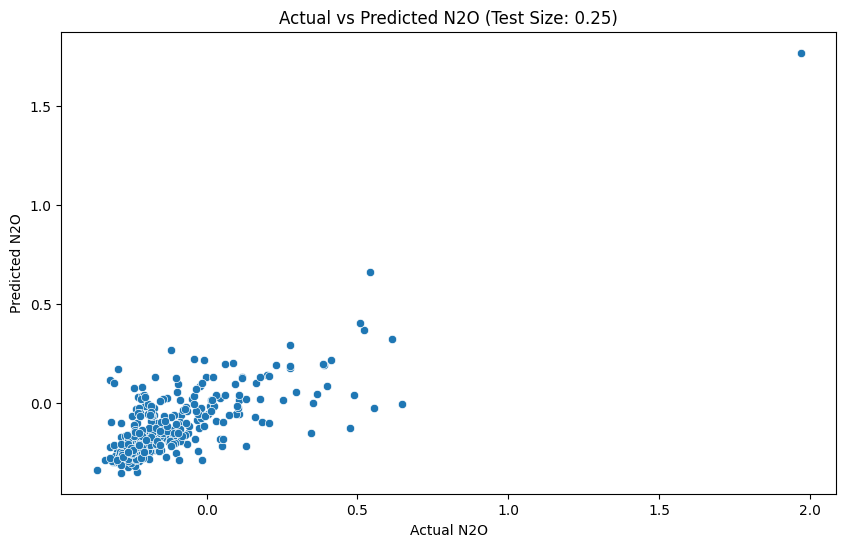

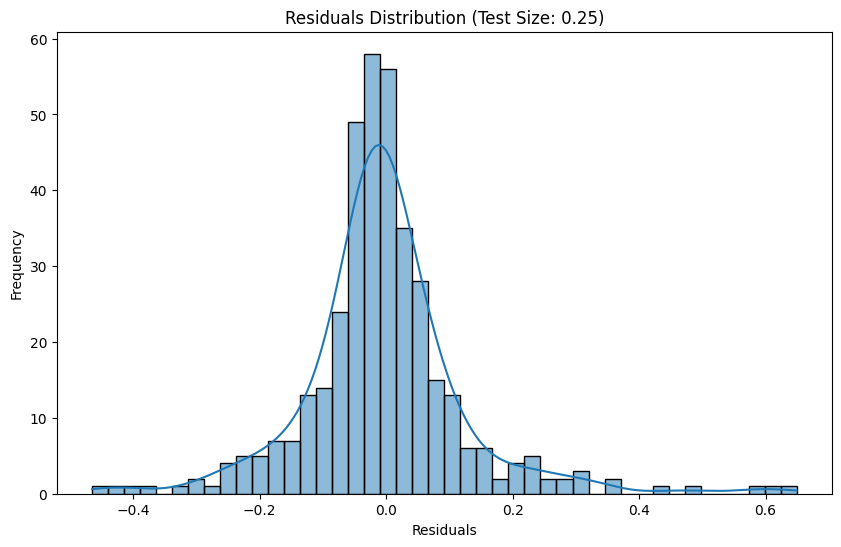

<Figure size 1000x600 with 0 Axes>

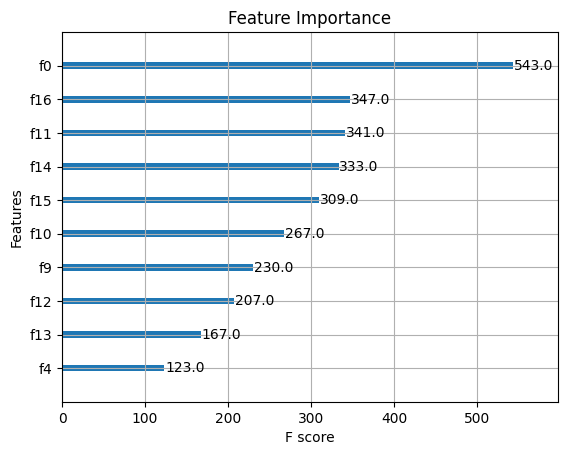

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.3
Mean Squared Error: 0.015488542832573234
Root Mean Squared Error: 0.12445297438218676
Mean Absolute Error: 0.07911286892429974
R-squared: 0.6173650172221141


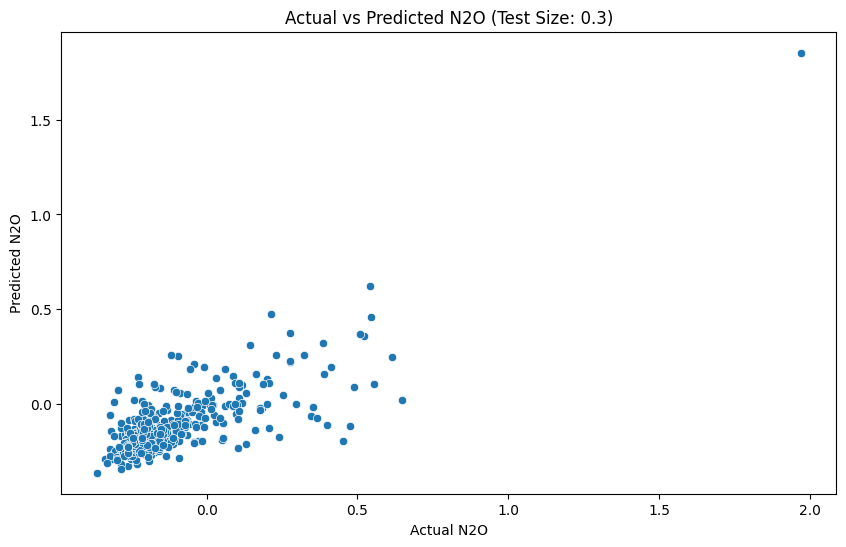

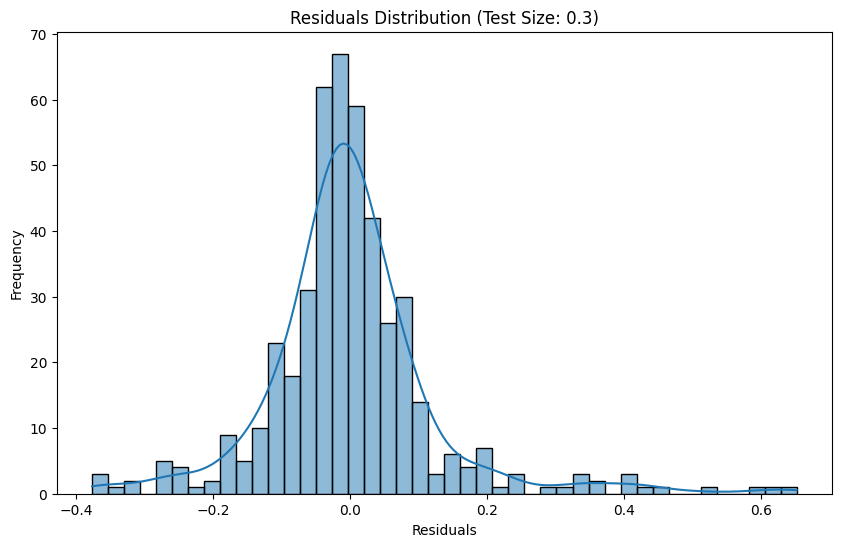

<Figure size 1000x600 with 0 Axes>

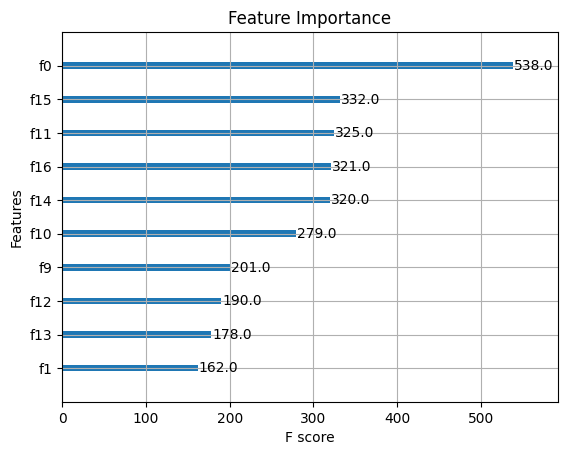

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.35
Mean Squared Error: 0.015218195827486819
Root Mean Squared Error: 0.12336205181289268
Mean Absolute Error: 0.07885952654817129
R-squared: 0.58759943186308


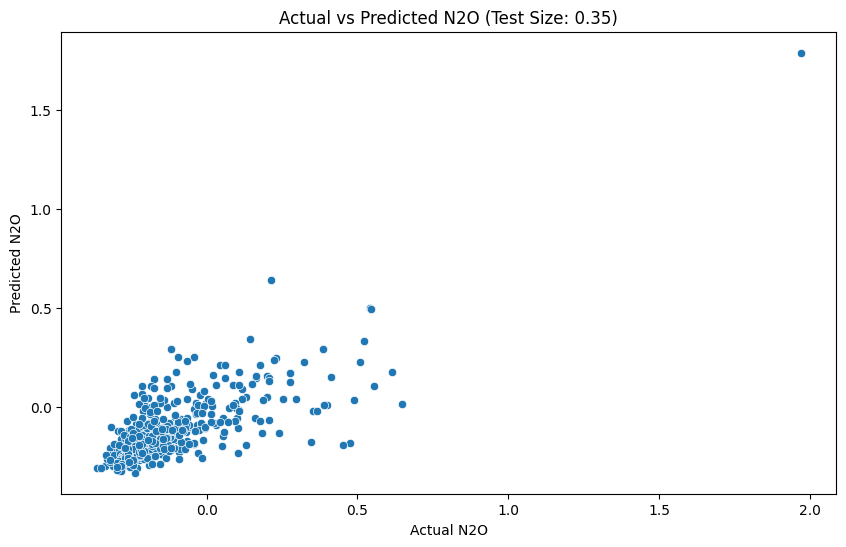

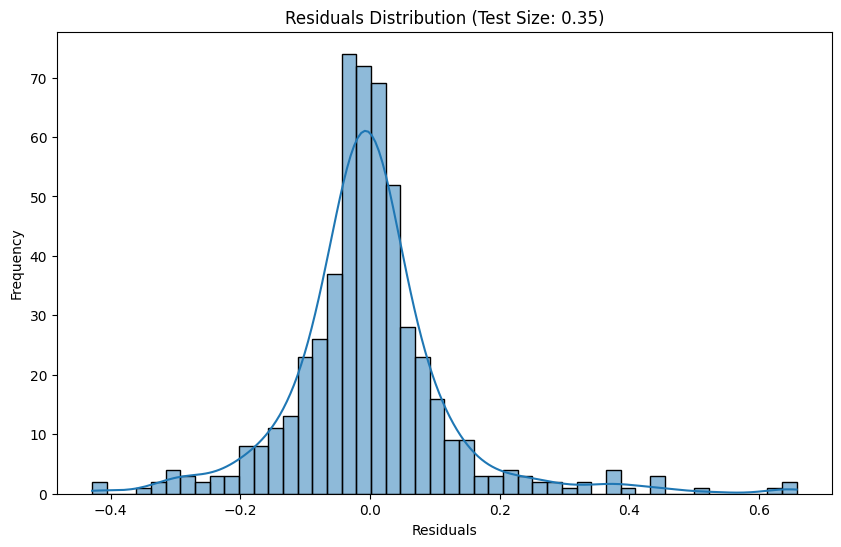

<Figure size 1000x600 with 0 Axes>

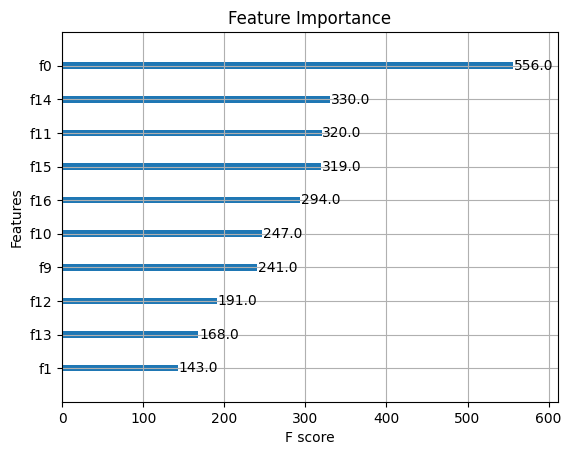

In [15]:

for test_size in test_sizes:
    model, mse, rmse, mae, r2 = train_and_evaluate(test_size)
    results[test_size] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}
    evaluation.append({
        'test_size': test_size,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })


In [16]:
# Convert results to a DataFrame
eval_df = pd.DataFrame(evaluation)

# Save the results to a CSV file
eval_df.to_csv('01.Dataset-Rofiqul/AfterRemoveOutliers/014_xgboost_evaluation_datauji_plain_results.csv', index=False)
